# Translation test

In [3]:
# some preliminary settings and functions

import sys
sys.path.append("/home/aunai/build_phare")
sys.path.append("/home/aunai/PHARE/pyphare/")
import os
import numpy as np
import pyphare
from pyphare.pharesee.hierarchy import finest_data
from pyphare.pharesee.hierarchy import hierarchy_from
from pyphare.pharesee.plotting import zoom_effect
import matplotlib.pyplot as plt
from pyphare.pharesee.run import Run
from pyphare.pharesee.hierarchy import compute_hier_from
%matplotlib notebook


def plot_job(job, time, qty, file_idx=None,**kwargs):
    path = os.path.join(main_jobs_path, job)
    r = Run(path)
    t=time        
    B = r.GetB(t)
    N = r.GetNi(t)
    V = r.GetVi(t)
    if qty in ("Bx","By","Bz"):
        self = B
    if qty == "rho":
        self = N
    if qty in ("Vx", "Vy", "Vz"):
        self = V
    fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(8,6), sharex=True)
    colors = ["k", "b", "r"]
    for ilvl, lvl in self.patch_levels.items():
        for pidx, patch in enumerate(lvl.patches):
            pdata  = patch.patch_datas[qty]
            x,v = finest_data(pdata, ilvl, self)
            ax1.plot(x, v,label="lev{} - patch{}".format(ilvl, pidx),
                     marker='o', markersize=2, color=colors[ilvl])

    for ilvl,level in B.patch_levels.items():
        for patch in level.patches:
            dx = patch.dx
            x0 = patch.origin[0]
            x1 = (patch.box.upper[0]+1)*dx
            ax2.axvspan(x0, x1, color='b',ec='k', alpha=0.2,
                        ymin=ilvl/4, ymax=(ilvl+1)/4)

    ax1.set_title("{} at t = {}".format(job,t))

    ax1.set_ylim(kwargs.get("ylim",(-3.5, 3.5)))

    ax1.set_xlim(kwargs.get("xlim", (0,500)))
    if file_idx is not None:
        fig.savefig(path+'/'+job+"_"+qty+"_{:04d}.png".format(file_idx))
        plt.close(fig)
    return fig, ax1, ax2

In [4]:
# some variable definitions
main_jobs_path = "../phare_jobs/tests/functional/translation/"

jobs = [
        #"uni_vx0p5",           # uniform plasma Vx = 0.5 with hyperres
        #"uni_vx1",             # uniform plasma Vx = 1 with hyperres
        "uni_vx2",             # uniform plasma Vx = 2 with hyperres
        "uni_vxm2",            # uniform plasma with Vx=-2 with hyperres
         "uni_vxm2_nohyperres", # uniform plasma with Vx=-2 without hyperres
    
        "uni_vx2_nohyperres",  # uniform plasma Vx = 2
        "uni_vx2_norefine_nohyperres", #Vx=2, nu=0, no refinement
        "uni_vx2_norefine",     # Vx=2, nu=0.01, 3 refinement levels
        "td_vx2",               # td case with Vx=2 with hyperres
    
        # tangential discontinuity cases with no hypersistivity
        #"td_vx0p5",            # td case with Vx=0.5
        #"td_vx1",
        "td_vx2_nohyperres",    # td case, vx=2, nu=0, 3 refinement levels
        "td_vx2_norefine",      # td case, vx=2, nu=0.01, no refinement
        "td_vx2_norefine_nohyperres" #td case, vx=2, nu=0, no refinement
      ]

## Uniform plasma with drift velocity

In these tests we have: $B_y=1$ and $n=1$


### $\nu = 0$ and $V_x=2$ with 3 refinement levels

No specific issue is since at patch boundaries, only level boundaries, and more specifically at the downstream level boundary. All happens as if fine grid-scale fluctuations that cannot propagate on the next coarser domain pile up at the edge of the level. Because of the flow, this pile-up occurs at the downstream boundary

<IPython.core.display.Javascript object>


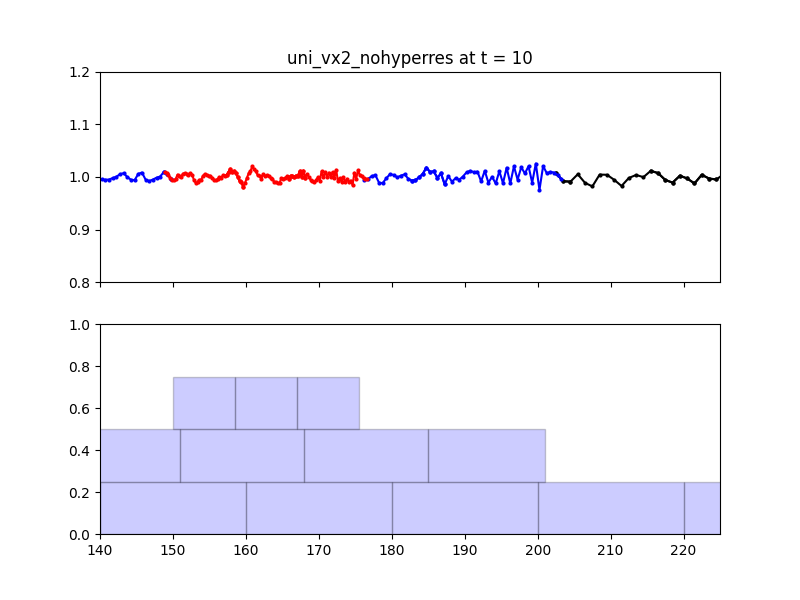

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc499a5c400>)

In [5]:
plot_job("uni_vx2_nohyperres", 10, "By", ylim=(0.8,1.2),xlim=(140,225))

<IPython.core.display.Javascript object>


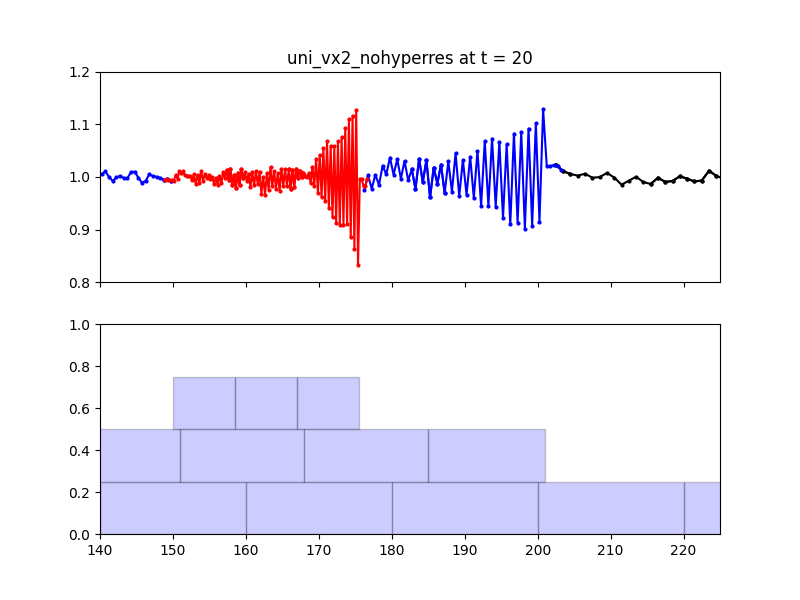

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc4995ac220>)

In [6]:
plot_job("uni_vx2_nohyperres", 20, "By", ylim=(0.8,1.2),xlim=(140,225))

### $\nu = 0$ and $V_x=2$ and no refinement

No specifc issue is seen after T = $20\Omega_{ci}^{-1}$. This confirms the issue seen in the refined case is due to level boundaries and not patch boundaries.

<IPython.core.display.Javascript object>


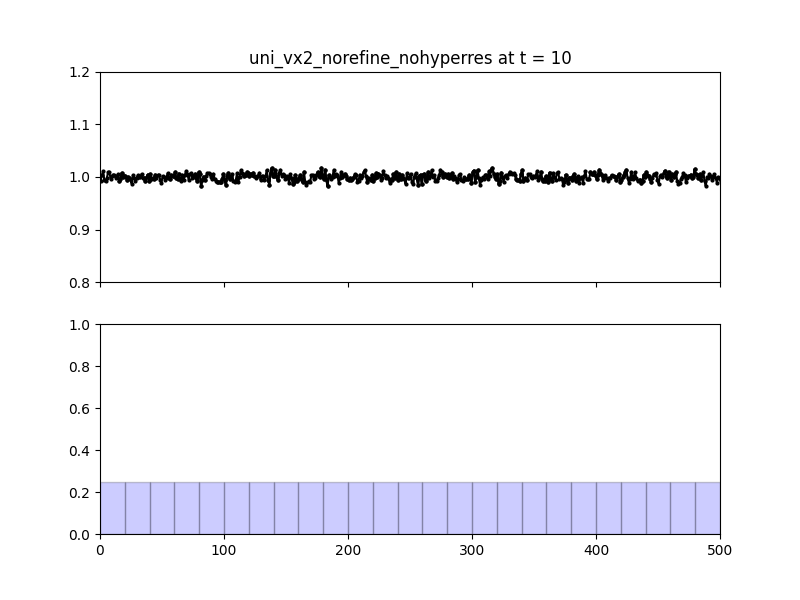

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc499102a30>)

In [8]:
plot_job("uni_vx2_norefine_nohyperres", 10, "By", ylim=(0.8,1.2),xlim=(0,500))

<IPython.core.display.Javascript object>


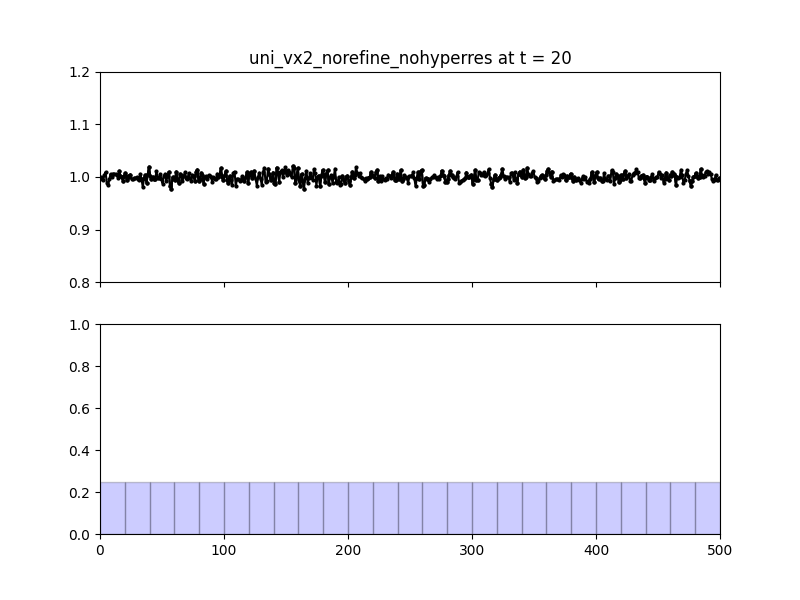

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc498bea550>)

In [9]:
plot_job("uni_vx2_norefine_nohyperres", 20, "By", ylim=(0.8,1.2),xlim=(0,500))

In [ ]:
#movie
for it,t in enumerate(np.arange(0.,20,0.1)):
    plot_job("uni_vx2_norefine_nohyperres", t, "By", it, ylim=(0.8,1.2), xlim=(0,500))

### $\nu = 0.01$, $V_x=2$, with refinement

One idea is that for a plasma at rest, there are as many waves going leftward and rightward, which causes no specific issue at level boundaries (see the **static tangential discontinuity test**). On the other hand, with a net rightward flow, wave are globally convected rightward.

Since there is a factor 2 refinement ratio between levels, all waves propagating on $L_i$ can propagate on the next coarser level $L_{i-1}$ BUT the waves at $\lambda = 2\Delta x_i = \Delta x_{i-1}$. These smallest wavelength waves on $L_i$ are convected to the downstream boundary but cannot cross it. The flow continuously brings energy at this wavelength at the $L_i$ border, even if this is not much per time unit, it starts to pile-up. The pile-up propagates upstream (leftward) while growing at the boundary, eventually leading to a crash. 

One idea is to kill these wave in the egg, i.e. not allowing them to exist long enough to pile-up. This could be done by applying a well chosen wide band low pass filter that would remove the $2\Delta x_i$ part of the signal, and that is probably the cleaner approach since this is typically a component of the signal that we do not want anywhere, even well inside domain.

A quick way of testing this idea (while not exactly controlling the scale as well as the filter mentioned above) is to turn on the hyper-resistivity term is Ohm's law : 

\begin{equation}
E_{hr} = -\nu\nabla^2\mathbf{j}
\end{equation}

which has the nice property of dominating over the electron convection electric field at small scale. Such a term would efficiently diffuse signal at small scale and prevent pile up.


In this test we test this idea by setting $\nu = 0.01$ (a rather strong value) everywhere in all patches at all times.


<IPython.core.display.Javascript object>


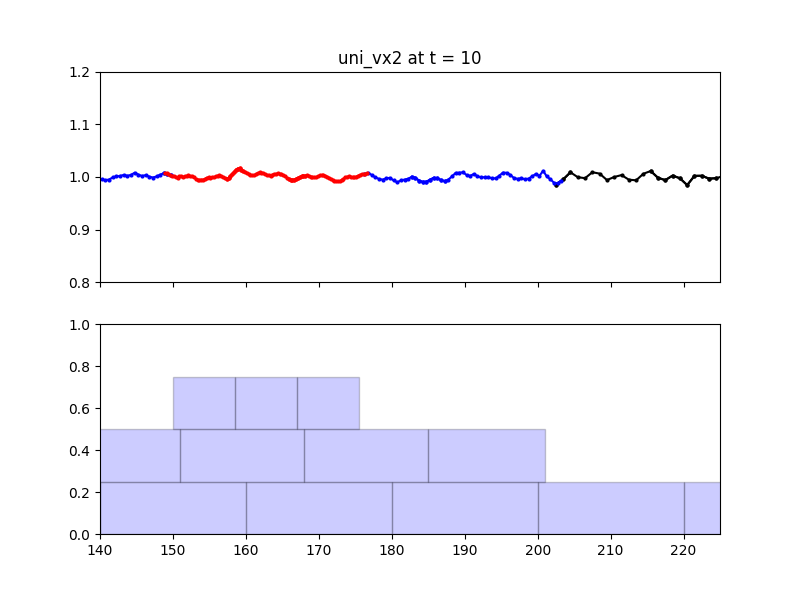

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc498767160>)

In [10]:
plot_job("uni_vx2", 10, "By", ylim=(0.8,1.2),xlim=(140,225))

<IPython.core.display.Javascript object>


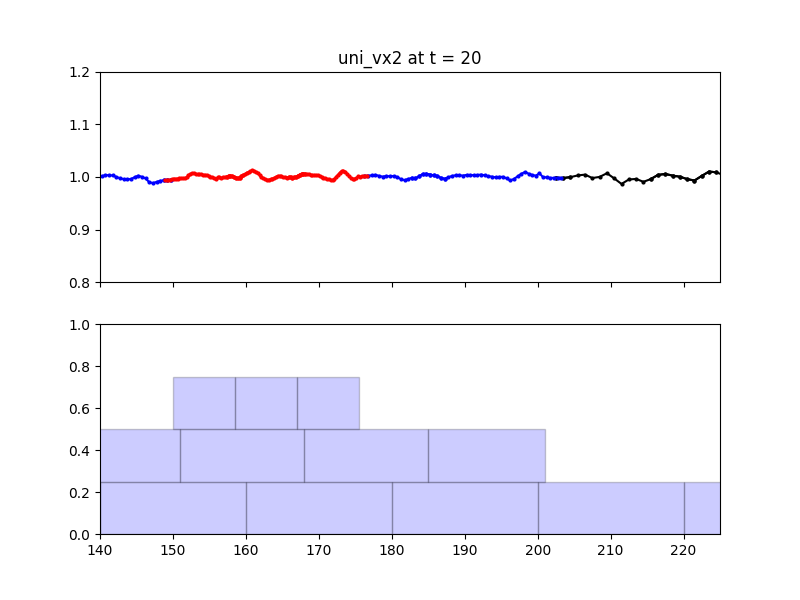

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc498279850>)

In [11]:
plot_job("uni_vx2", 20, "By", ylim=(0.8,1.2),xlim=(140,225))

At t=10 and t=20 it is clear that no problem is seen at the level boundary as in the non-diffusive run. This indicates that the hyper-resistivity is able to efficiently diffuse away grid-scale waves before they get convected and piled-up at the level boundary.

We still see some occasional minor discontinuity, at the L1-L0 interface that may diserve some further investigation. At this point $\nu$ is constant everywhere and above all it is constant across levels. It would appear better to set a $\nu$ *per level* so that diffusion is fine tuned to be effective the closest to the mesh scale. On the other hand one can also imagine that for a given mesh size the diffusion does not need to be as strong for slower flows, because slower flow means more time to diffuse the same signal.

### $\nu = 0.01$, $V_x=2$, no refinement

This test is not super useful but done anyway.
It illustrates the role of hyper-resistivity rather than anything else.
We can see the magnetic field is a bit smoother than without hyperresistivity, still no issue

<IPython.core.display.Javascript object>


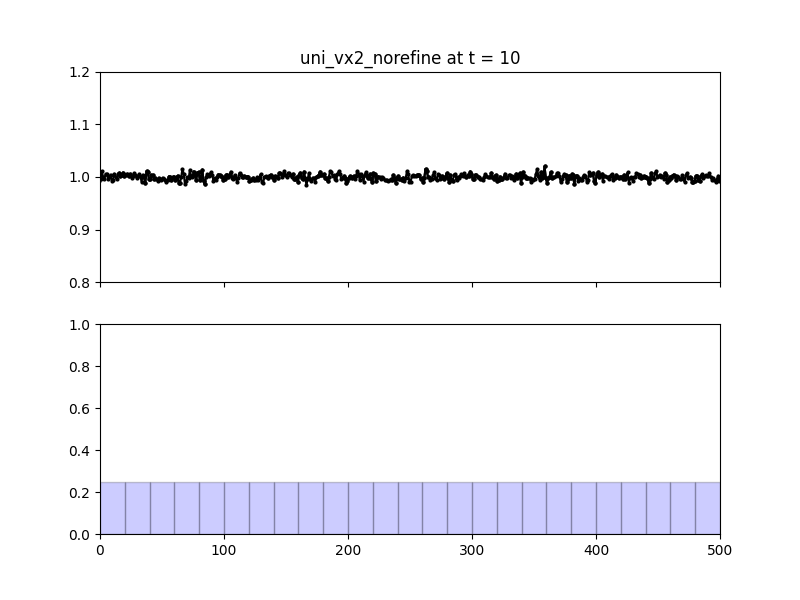

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc497dcc5e0>)

In [12]:
plot_job("uni_vx2_norefine", 10, "By", ylim=(0.8,1.2),xlim=(0,500))

<IPython.core.display.Javascript object>


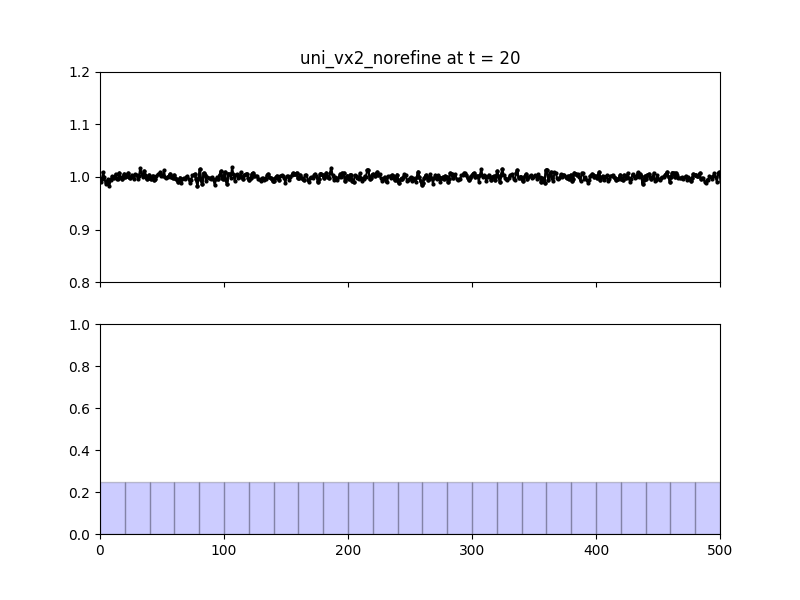

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc497924e50>)

In [13]:
plot_job("uni_vx2_norefine", 20, "By", ylim=(0.8,1.2),xlim=(0,500))

In [ ]:
#movie
for it,t in enumerate(np.arange(0.,20,0.1)):
    plot_job("uni_vx2_norefine", t, "By", it, ylim=(0.8,1.2), xlim=(0,500))

### $\nu=0.0$ and opposite velocity $V_x=-2$
this test is the same as the uniform refined case done above but this time the velocity is reversed.
The fact that the oscillation appears on the left confirms the issue is the energy pile-up at the downstream level border due to the impossible crossing of grid scale waves

<IPython.core.display.Javascript object>


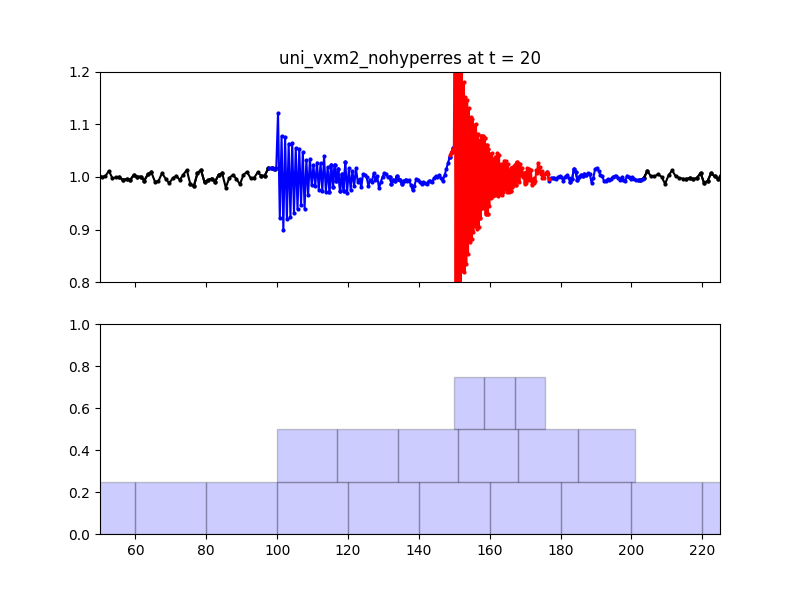

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc4974313a0>)

In [14]:
plot_job("uni_vxm2_nohyperres", 20, "By",ylim=(0.8,1.2),xlim=(50,225))

### $\nu=0.01$ and $V_x=-2$

<IPython.core.display.Javascript object>


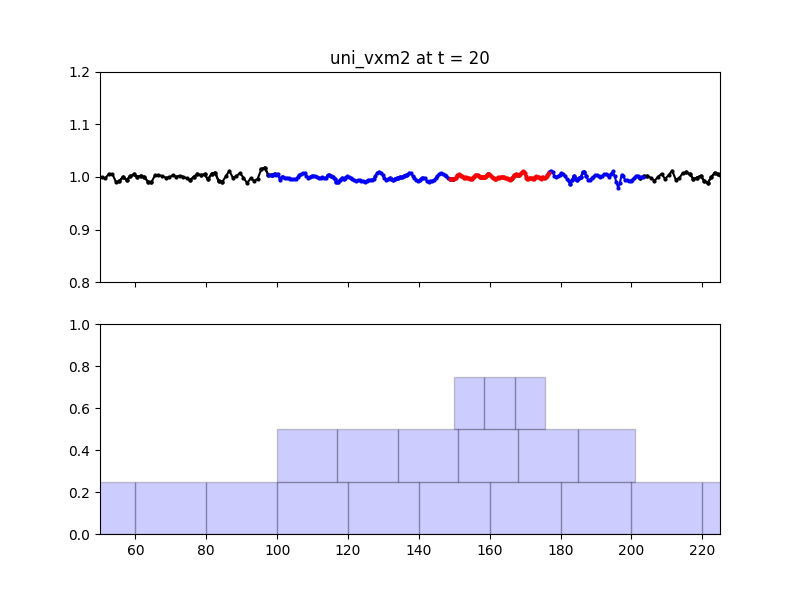

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc4972e20d0>)

In [15]:
plot_job("uni_vxm2", 20, "By",ylim=(0.8,1.2),xlim=(50,225))

In [ ]:
#movie
for it,t in enumerate(np.arange(0.,20,0.1)):
    plot_job("uni_vx2_norefine", t, "By", it, ylim=(0.8,1.2), xlim=(0,500))

## Moving tangential discontinuity

In this test the initial condition is a tangential discontinuity with $B_y = tanh((y-y_0)/\lambda)$, a constant density $n=1$, $B_z=0.5$ and a pressure balance obtained via the temperature profile. As for the uniform plasma case, we impose a uniform drift velocity $V_x=2$


###  Without hyper-resistivity

Without hyper-resistivity we observe the same pile-up behavior we had in the homogeneous case. The sharp gradients brought by the hyper-resistivity only make things worse. The grid-scale pile-up occuring at level boundaries leaks to the coarser domain and alters the coarse signal even.

<IPython.core.display.Javascript object>


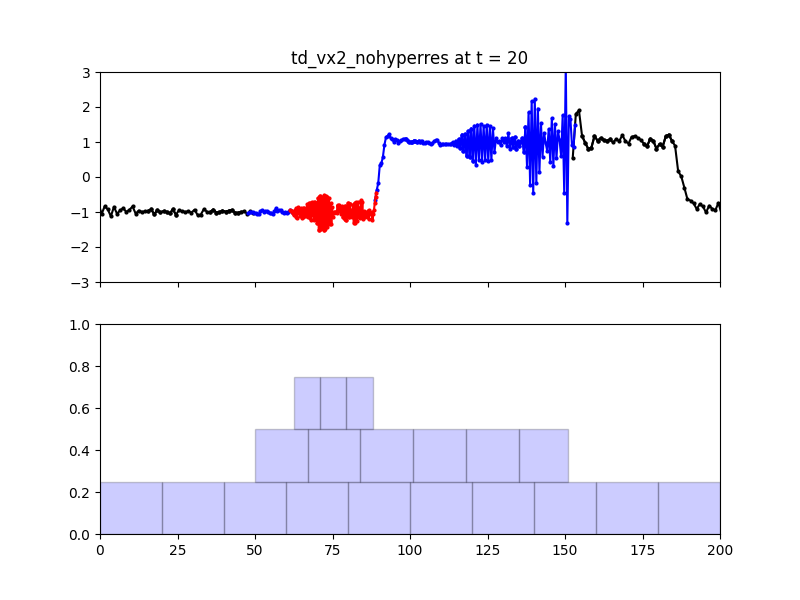

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc4971cfd00>)

In [16]:
plot_job("td_vx2_nohyperres", 20, "By", ylim=(-3,3),xlim=(0,200))

### $\nu=0$, $V_x=2$ with no refinement

Same non-diffusive run but this time with no refinement. As for the uniform case, we do not have specific issues at patch boundaries indicating the problem really is at level boundaries.
We note some oscillations at the leading and trailing edges of the propagating discontinuities, that are a priori caused by the under resolved sharp gradient.

<IPython.core.display.Javascript object>


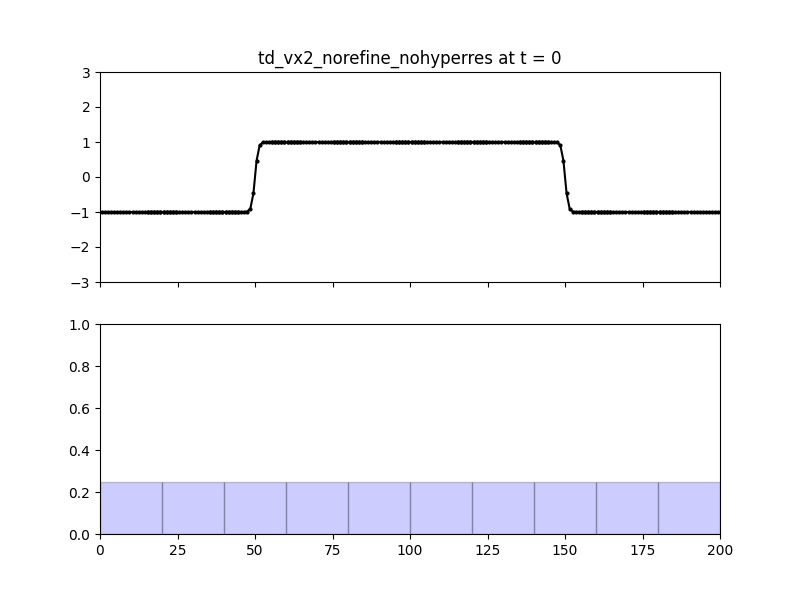

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc49bb50940>)

In [17]:
plot_job("td_vx2_norefine_nohyperres", 0, "By", ylim=(-3,3),xlim=(0,200))

<IPython.core.display.Javascript object>


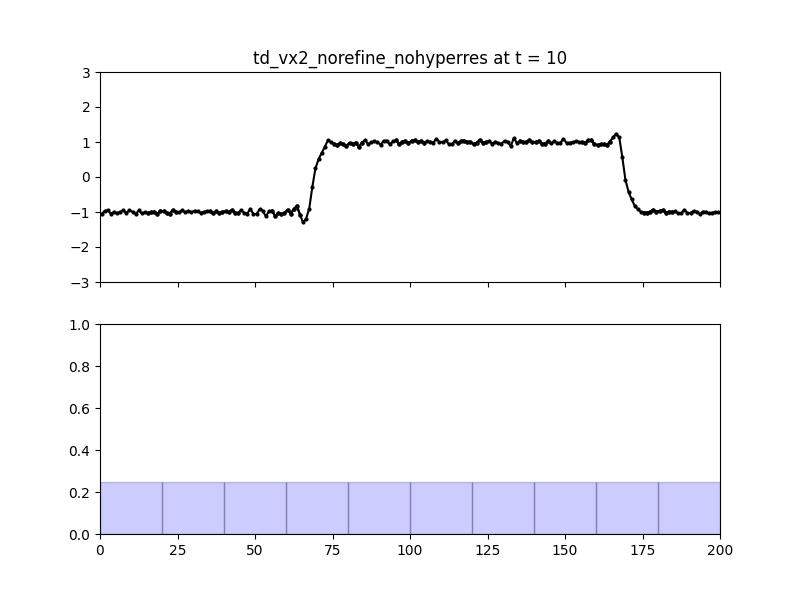

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc49704cd90>)

In [18]:
plot_job("td_vx2_norefine_nohyperres", 10, "By", ylim=(-3,3),xlim=(0,200))

<IPython.core.display.Javascript object>


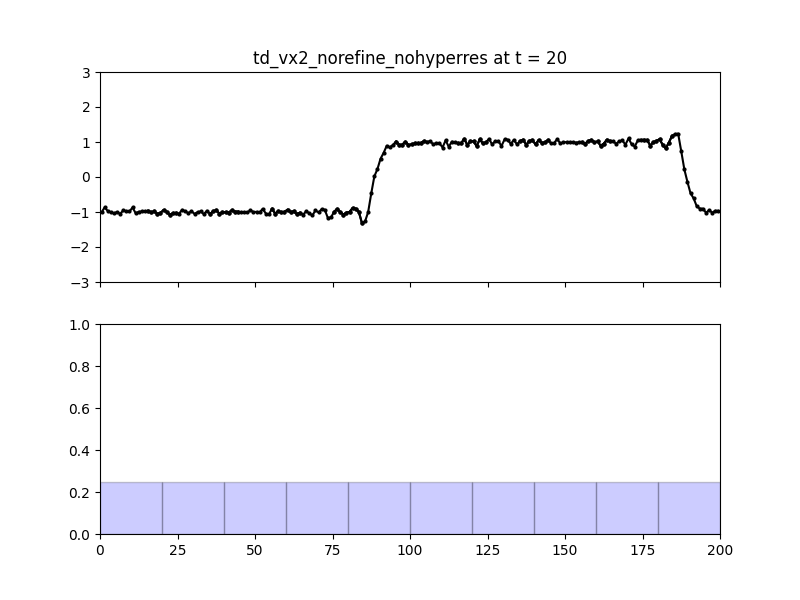

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc496f91580>)

In [19]:
plot_job("td_vx2_norefine_nohyperres", 20, "By", ylim=(-3,3),xlim=(0,200))

###  $\nu = 0.01$, $V_x=2$ with refinement

This run turns on hyper resistivity on the tangential discontinuity case. We can now see that as for uniform cases, the diffusion is able to get rid of the grid-scale pile up at downstream edges of levels. 

We still see some oscillation at the leading and trailing edges of the discontinuities, but we can notice that they are, for the same times, less pronounced. This is probably a beneficial effect of the mesh refinement in this case. The leading edge of the signal has spent some time in the blue L1 level that has probably helped limiting/delaying the development of the oscillation. The trailing edge has spent all/most of its time in the most refined mesh region and we barely notice any oscillation, if compared to the non refined case.

<IPython.core.display.Javascript object>


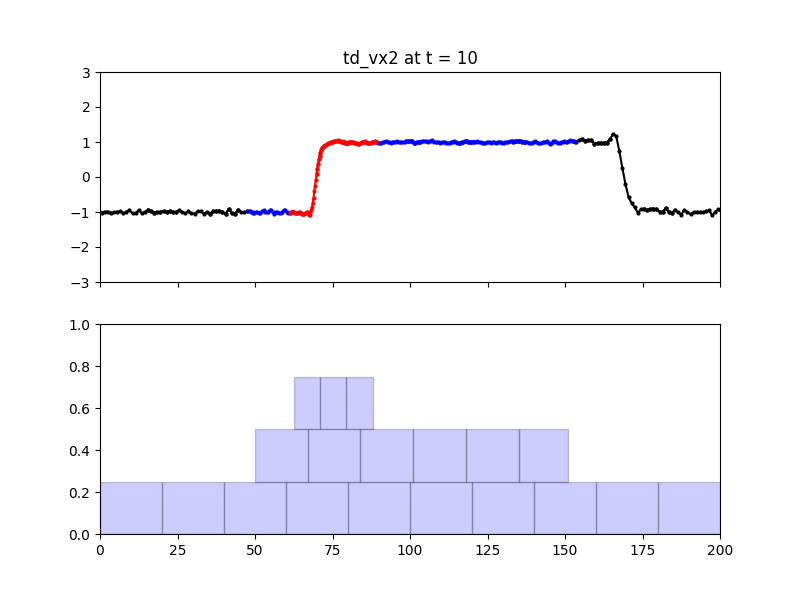

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc496e8d040>)

In [20]:
plot_job("td_vx2", 10, "By", ylim=(-3,3),xlim=(0,200))

<IPython.core.display.Javascript object>


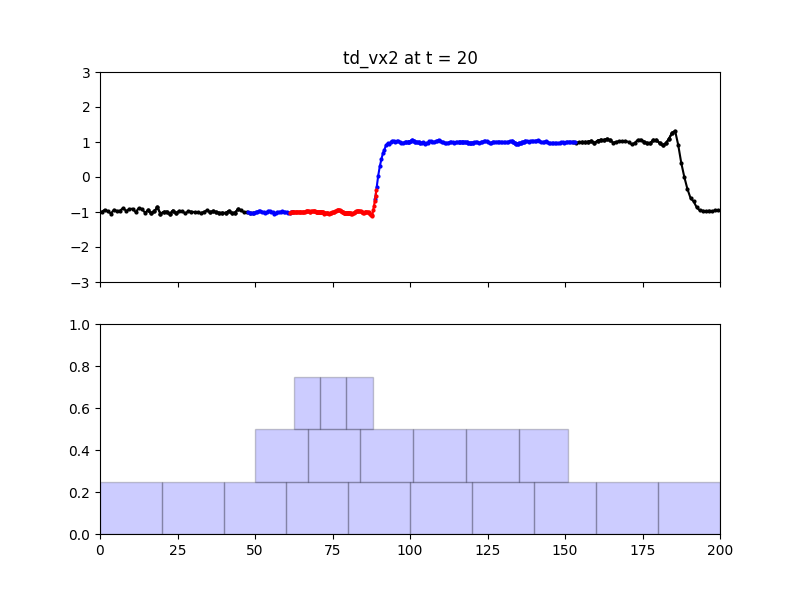

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc496d90130>)

In [21]:
plot_job("td_vx2", 20, "By", ylim=(-3,3),xlim=(0,200))

In [ ]:
#movie
for it,t in enumerate(np.arange(0.,20,0.1)):
    plot_job("td_vx2", t, "By", it, ylim=(-3,3), xlim=(0,200))

### $\nu = 0.01$,  $V_x=2$ and no refinement

As for the uniform case this test is not critical and mostly shows the effect of the hyper-resistivity. We see the signal is smoother than in the non-diffusive non refined case as it should. But we also see that the leading/trailing edges oscillations are almost as pronounced. This is because 1/ we do not have refinement, 2/ these oscillations are at a scale that is too large for hyper-resistivity to be efficient. They would probably be diffused by classical Joule diffusion $E_j = \eta\mathbf{j}$ 

<IPython.core.display.Javascript object>


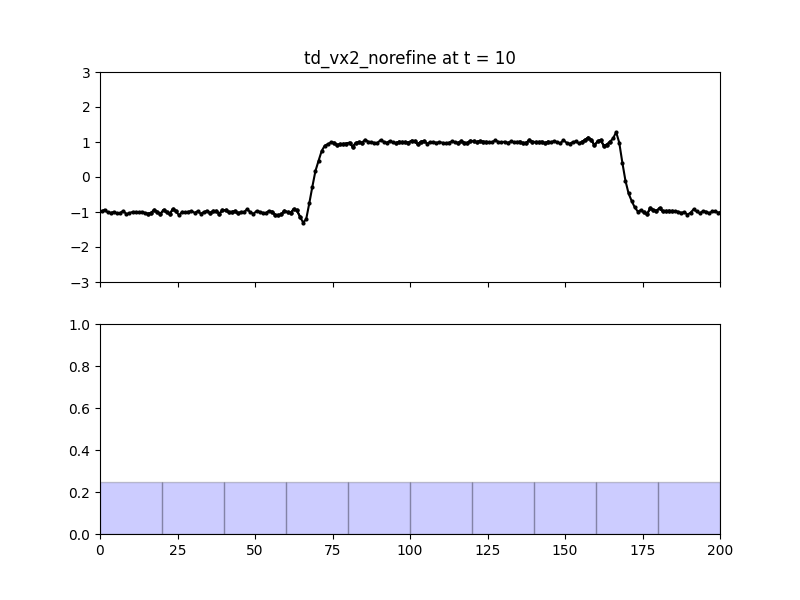

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc496f3fbe0>)

In [22]:
plot_job("td_vx2_norefine", 10, "By", ylim=(-3,3),xlim=(0,200))

<IPython.core.display.Javascript object>


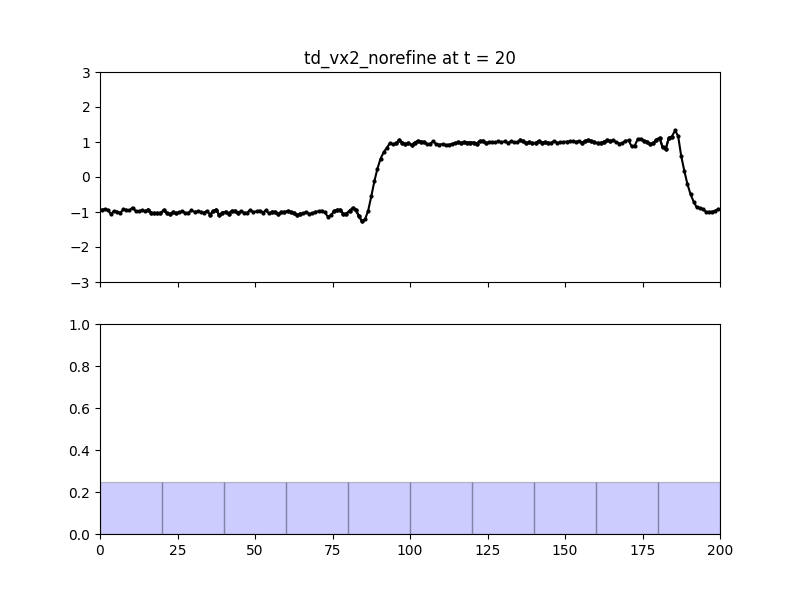

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc496c0adf0>)

In [23]:
plot_job("td_vx2_norefine", 20, "By", ylim=(-3,3),xlim=(0,200))

In [ ]:
#movie
for it,t in enumerate(np.arange(0.,20,0.1)):
    plot_job("td_vx2_norefine", t, "By", it, ylim=(-3,3), xlim=(0,200))